# Stich together monthly BC files

Script to stich together bias corrected files. After ESM bias correction by month, files are grouped by month (+/- 15 day buffer). This script removes the 15 day buffer and saves the output as yearly files. 

orginal by Ryan Currier, A.Smith, modified by Bert Kruyt March 2023


In [1]:
import xarray as xr
import dask
import glob
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import multiprocessing as mp
import time, calendar

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [18]:
# The path where the monthly output of the ESM bias correction was written to:
mon_BC_path = "/glade/scratch/bkruyt/CMIP6/monthly_BC_3D/"

# the path to the original (non-BC) monthly GCM:
raw_mon_path = "/glade/scratch/bkruyt/CMIP6/raw_month/"

# dir for merged output:
out_dir = '/glade/scratch/bkruyt/CMIP6/BC_3D_merged/'


modelLs=['CESM2']#['CMCC-CM2-SR5', 'NorESM2-MM'] # ['CanESM5']#['CESM2','CMCC-CM2-SR5','CNRM-ESM2-1','MIROC-ES2L']
scenarios=[ 'ssp585', 'ssp370'] #['historical' , 'ssp585', 'ssp370'] # ['historical'] # ['ssp585'] #['ssp370'] # ['ssp585' ] # ,  

# If data was processed in five year chunks, set this to true:
five_year_chunks=False

# Add variable attributes back in? These have been 'lost' in bias-correction
add_attrs=True


## Verify time (optional)

Plot the input and output time variable for a specific month to see if they allign, and are discontinuous

The first plot should show a discontinuous blue line on top of a continuous red line

Note this does not work for noleap calendar models, because the ESM bias correction transforms time to proleptic gregorian(?)


('proleptic_gregorian', 'proleptic_gregorian')

noleap proleptic_gregorian
(15859,) (15856,)
proleptic_gregorian proleptic_gregorian


/glade/scratch/bkruyt/ipykernel_54931/394120298.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dsRaw['time'] = dsRaw.indexes['time'].to_datetimeindex()


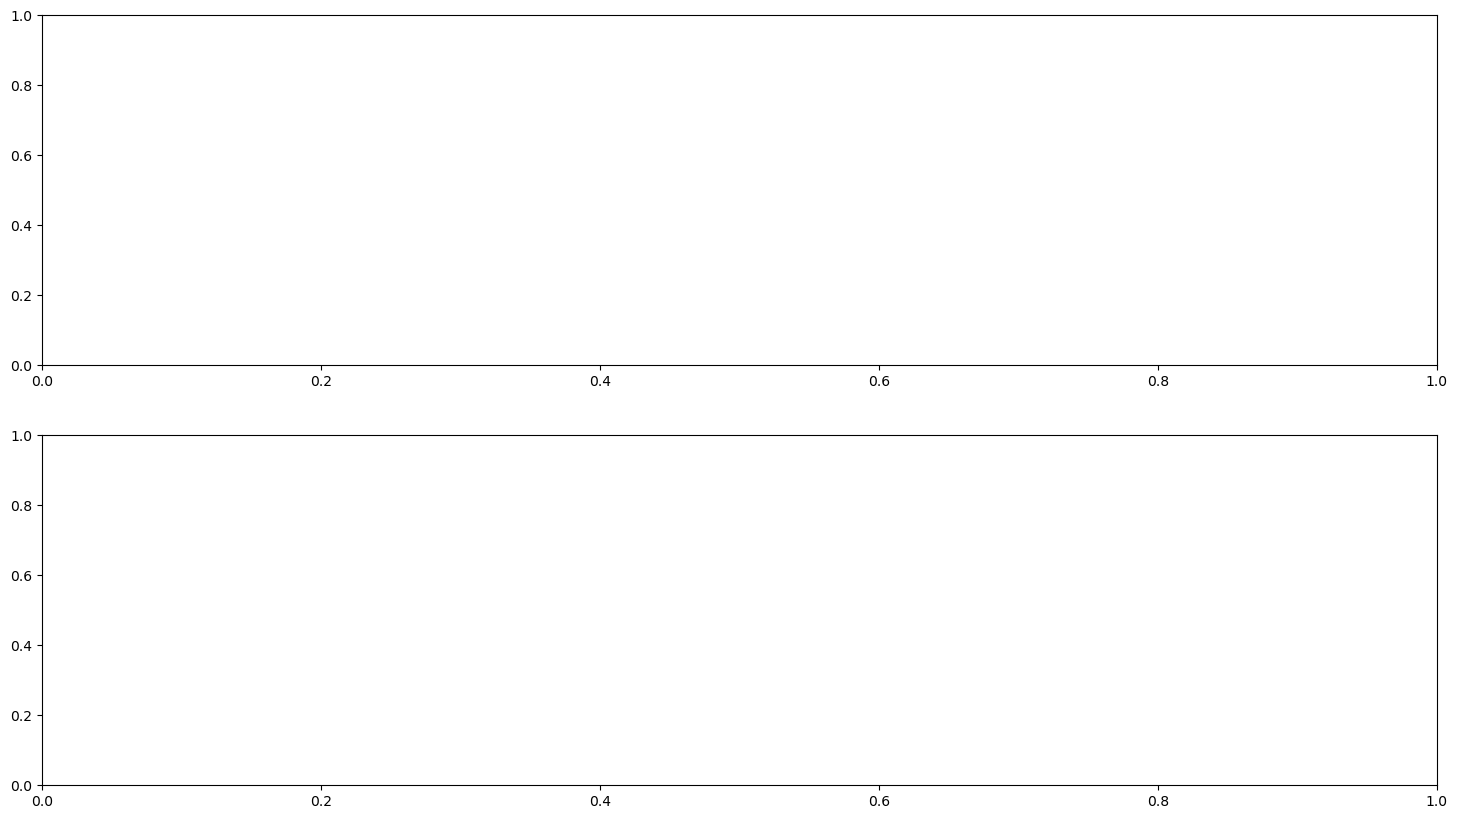

In [17]:
month=1

scen=scenarios[0]; mod=0 


dsRaw=xr.open_mfdataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+'_'+str(month).zfill(2)+".nc")
dsTmp=xr.open_mfdataset(mon_BC_path+modelLs[mod]+"/"+scen+'/'+"bias_corrected_*_"+str(month).zfill(2)+".nc")

print(dsRaw.time.dt.calendar, dsTmp.time.dt.calendar)
print(dsRaw.time.shape, dsTmp.time.shape)

try:
    print(dsRaw.time.values.min().astype('datetime64[D]'), dsRaw.time.values.max().astype('datetime64[D]'))
except:
    dsRaw['time'] = dsRaw.indexes['time'].to_datetimeindex()

print(dsRaw.time.dt.calendar, dsTmp.time.dt.calendar)


# Plot
fig, ax = plt.subplots(2,1, figsize=(18,10) )
# if dsRaw.time.dt.calendar != 'noleap' :
if dsRaw.time.shape == dsTmp.time.shape :
    ax[0].scatter(dsRaw.time.values[:], dsTmp.time.values[:])
    ax[0].set_title('time input vs output  (should lie on red y=x line and be discontinuous')
    ax[0].set_xlabel('input GCM time (before BC)')
    ax[0].set_ylabel('output GCM time (after BC)')
    ax[0].axline((dsRaw.time.dt.year.values[0], dsTmp.time.dt.year.values[0]), slope=1, color='red') # plot y=x line to validate
    ax[0].set_ylim(dsTmp.time.values[0], None)
    ax[0].set_xlim(dsRaw.time.values[0], None)

    # Plot BC temp:
    ax[1].scatter(dsTmp.time.values, dsTmp.T.values[:,0,9,19] )
    ax[1].set_title('Temperture at lev=0; j,i=9,19')
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('K'  ) 

    plt.show()

## Stitch files back together

### Serial version

stich monthly files back together

optionally add in the variable attributes that have been lost during Bias correction

In [19]:
%%time


for mod in range(len(modelLs)):
    for scen in scenarios:

        if not os.path.exists(out_dir + modelLs[mod]+'/'+scen):
                os.makedirs( out_dir + modelLs[mod]+'/'+scen )  

        print(modelLs[mod], scen)

        if five_year_chunks:
            if scen == "historical":
                year_start=np.arange(1950, 2015, 5)
                year_end=np.arange(1954, 2019, 5)
            else:
                year_start=np.arange(2015, 2099, 5)
                year_end=np.arange(2019, 2100, 5)
        else: # in case of ~32 year blocks:
            if scen == "historical":
                year_start = ['1950','1982']
                year_end = ['1981','2014']
            else:
                year_start = ['2015','2047','2079']
                year_end = ['2046','2078','2100']

        # load one original GCM file so we can put the variable attributes back:
        dsRaw=xr.open_dataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_01.nc")
        
        
        # Loop through the bias-corrected monthly files and recombine:
        for t in range(len(year_start)):

            print(year_start[t], "-", year_end[t])
            ds_month={}

            for month in range(1,13):
                print('   month = '+str(month).zfill(2))
              
                # Load the bias corrected dataset
                dsBC=xr.open_mfdataset(mon_BC_path+modelLs[mod]+"/"+scen+'/'+"bias_corrected_"+
                                        str(year_start[t])+"-"+str(year_end[t])+"_"+str(month).zfill(2)+".nc")

                # OPTIONAL: put variable attributes back
                if add_attrs:
                    # print("   adding variable attributes back in" )
                    for var in dsBC.data_vars:
                        if var == 'z':
                            # dsBC[var].attrs = dsRaw['Z'].attrs # this is empty as well
                            dsBC.z.attrs['comment']="monthly values held constant over the month's duration."
                        elif var != 'z':
                            dsBC[var].attrs = dsRaw[var].attrs
                          
                        
                # Because the Fortran ESM code does not output the correct time, we overwrite with the original. 
                # I don't like this and ideally we should modify the fortran code to do the right thing.... (Has been modified)
                # dsGCMraw=xr.open_dataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_"+str(month).zfill(2)+".nc")
                # dsBC['time']=dsGCMraw['time'].sel(time=slice(start_time[t], end_time[t])) 

                dsGroup=dsBC.groupby(dsBC['time'].dt.month).groups

                # drop the buffer time periods +/- 15 days
                ds_month[str(month).zfill(2)]=dsBC.isel(time=dsGroup[month]) 
                
                #remove any possible duplicate values (and load):
                ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(
                    time=~ds_month[str(month).zfill(2)].get_index("time").duplicated()).load() 
                
                # expand the z variable to include time (somehow the bc code removes the time component of z?)
                ds_month[str(month).zfill(2)]['z'] = ds_month[str(month).zfill(2)].z.expand_dims(time=len(ds_month[str(month).zfill(2)].time))
                # ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=slice(start_time[t],end_time[t])).drop('z') # slice and drop z variable - BK:why?
                
   
            # Merge months and save as yearly datasets (30 yr takes long/large mem demand).
            # This could be modified to save an arbitrary amount of years per file
            print('   loaded datasets, now merge `em')
            for yr in range(int(year_start[t]), int(year_end[t])): # can we parallelize this?
                t1=time.time()

                # merge the 12 months of year 'yr' into one dataset:
                dsOut=xr.merge(
                    [ds_month[str(month).zfill(2)].sel(
                        time=ds_month[str(month).zfill(2)].time.dt.year==yr
                    ) for month in range(1,13)]
                )
                
                # Check if the years have the correct length: (this is not complete, if in doubt, check manually afterwards)
                if dsOut.time.dt.calendar=='noleap' and len(dsOut.time)!=1460:
                    print("   !!! "+str(yr)+" has length ", dsOut.time.shape, " while it should be 1460 ")
                elif dsOut.time.dt.calendar=='proleptic_gregorian':
                    if (not (calendar.isleap(np.unique(dsOut.time.dt.year))) and (len(dsOut.time)!=1460) ): # if not a leap year the length should be 1460
                         print("   !!! "+str(yr)+" has length ", dsOut.time.shape, " while it should be 1460 ")
                    elif calendar.isleap(np.unique(dsOut.time.dt.year)) and (len(dsOut.time)!=1464): # if a leap year the length should be 1464
                          print("   !!! "+str(yr)+" has length ", dsOut.time.shape, " while it should be 1464 ")
                    else: print('      merged year '+str(yr) ,' time: ', round(time.time()-t1, 2) )
                else:
                    print( "   calendar is ", dsOut.time.dt.calendar )

                
                t2= time.time()
                dsOut.to_netcdf(out_dir + modelLs[mod]+'/'+scen+'/'+modelLs[mod]+'_BC_'+str(yr)+'.nc',  
                                encoding={'time':{'units':"days since 1900-01-01"}}) 
                print('      saved year '+str(yr)+' to '+ out_dir + modelLs[mod]+'/'+modelLs[mod]+'_BC_'+str(yr)+'.nc' ,
                     'time:  ', time.time()-t2)

                # del dsOut         

            # del ds_month



CESM2 ssp585
2015 - 2046
   month = 01
   month = 02
   month = 03
   month = 04
   month = 05
   month = 06
   month = 07
   month = 08
   month = 09
   month = 10
   month = 11
   month = 12
   loaded datasets, now merge `em
   !!! 2015 has length  (836,)  while it should be 1460 
      saved year 2015 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/CESM2/CESM2_BC_2015.nc time:   2.196861743927002
   !!! 2016 has length  (796,)  while it should be 1464 
      saved year 2016 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/CESM2/CESM2_BC_2016.nc time:   0.4693946838378906
   !!! 2017 has length  (788,)  while it should be 1460 
      saved year 2017 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/CESM2/CESM2_BC_2017.nc time:   0.4403078556060791
   !!! 2018 has length  (788,)  while it should be 1460 
      saved year 2018 to /glade/scratch/bkruyt/CMIP6/BC_3D_merged/CESM2/CESM2_BC_2018.nc time:   0.5946271419525146
   !!! 2019 has length  (788,)  while it should be 1460 
      saved year 2019 to 

KeyError: 2

### Parallel version 
under development (feel free to modify)

In [7]:

def merge_and_save_yr(ds_month, yr, month,
                      out_dir, model, scen):
    t1=time.time()
    dsOut=xr.merge(
        [ds_month[str(month).zfill(2)].sel(
            time=ds_month[str(month).zfill(2)].time.dt.year==yr
        ) for month in range(1,13)]
    ).load()
    print('      merged year '+str(yr) ,' time: ', time.time()-t1)
    t2= time.time()
    dsOut.to_netcdf(out_dir + model+'/'+scen+'/'+model+'_BC_'+str(yr)+'.nc')
    print('      saved year '+str(yr)+' to '+ out_dir + model+'/'+model+'_BC_'+str(yr)+'.nc' 
         ,'time:  ', time.time()-t2)
    

In [ ]:
%%time
Nprocs=8

for mod in range(len(modelLs)):
    for scen in scenarios:

        if not os.path.exists(out_dir + modelLs[mod]+'/'+scen):
                os.makedirs( out_dir + modelLs[mod]+'/'+scen )  

        print(modelLs[mod], scen)

        if scen == "historical":
            year_start = ['1950','1982']
            year_end = ['1981','2014']
        else:
            year_start = ['2015','2047','2079']
            year_end = ['2046','2078','2100']
            
        # load one original GCM file so we can put the variable attributes back:
        dsGCMraw=xr.open_dataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_01.nc")
        

        # for t in range(1): # testing
        for t in range(len(year_start)):
            print(year_start[t], "-", year_end[t])
            ds_month={}

            for month in range(1,13):
            # for month in range(1,2):  # for Testing only
                print('   month = '+str(month).zfill(2))

                # Load the bias corrected dataset
                dsBC=xr.open_mfdataset(mon_BC_path+modelLs[mod]+"/"+scen+'/'+"bias_corrected_"+
                                        year_start[t]+"-"+year_end[t]+"_"+str(month).zfill(2)+".nc")

                # OPTIONAL: put variable attributes back
                for var in dsBC.data_vars:
                    if var != 'z':
                        dsBC[var].attrs = dsRaw[var].attrs
                        # print(dsBC[var].attrs, '\n')

    #             # dsGCMraw=xr.open_dataset(fileGCM[ month - 1])
                # dsGCMraw=xr.open_dataset(raw_mon_path+modelLs[mod]+"/"+scen+'/'+modelLs[mod]+"_"+str(month).zfill(2)+".nc")
    #             # dsBC['time']=dsGCMraw['time'].sel(time=slice(start_time[t], end_time[t])) # what is this??

                dsGroup=dsBC.groupby(dsBC['time'].dt.month).groups
        
                ds_month[str(month).zfill(2)]=dsBC.isel(time=dsGroup[month]) # drop the buffer time periods +/- 15 days

                ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=~ds_month[str(month).zfill(2)].get_index("time").duplicated()) #remove any possible duplicate values
                
                
                # expand the z variable to include time (somehow the bc code removes the time component of z?)
                ds_month[str(month).zfill(2)]['z'] = ds_month[str(month).zfill(2)].z.expand_dims(time=len(ds_month[str(month).zfill(2)].time))
                # ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=slice(start_time[t],end_time[t])).drop('z') # slice and drop z variable - BK:why?
                
   

            # maybe .load() ds_month into memory now?
            # ds_month.load()
                    
            # Merge months and save as yearly datasets (30 yr takes very long/large mem demand).
            print('   loaded datasets, now merge `em')
            with mp.Pool(processes = Nprocs) as p:
                [p.apply( merge_and_save_yr, 
                         args=(ds_month, yr, month, out_dir, modelLs[mod], scen ))
                         for yr in range(int(year_start[t]), int(year_end[t])) ]
            
            del ds_month


## Original code (by Abby)

In [3]:
f1 = '/glade/scratch/abby/ESM_bias_correction/'
f_bias = '/ssp585/three_set/'
f2 = '/glade/scratch/abby/'
f_raw = '/icar_forcing/forcing_by_month/'

varz = ['p','qv','u','v','t']
modelLs=['CESM2','CMCC-CM2-SR5','CNRM-ESM2-1','MIROC-ES2L']
for mod in range(len(modelLs)):
    print(modelLs[mod])

    year_start = ['1950','1955','1960','1965','1970','1975']
    year_end = ['1954','1959','1964','1969','1974','1979']
    start_time=['1950-01-01T12:00:00','1955-01-01T00:00:00','1960-01-01T00:00:00','1965-01-01T00:00:00','1970-01-01T00:00:00','1975-01-01T00:00:00']
    end_time=['1954-12-31T18:00:00','1959-12-31T18:00:00','1964-12-31T18:00:00','1969-12-31T18:00:00','1974-12-31T18:00:00','1979-09-30T18:00:00']
    
    for t in range(len(year_start)):
        print(year_start[t])
        file=sorted(glob.glob('/glade/scratch/abby/ESM_bias_correction/' +modelLs[mod]+ '/ssp585/bias_corrected_'+year_start[t]+'-'+year_end[t]+'_*.nc'))
        fileGCM=sorted(glob.glob(f2 +modelLs[mod]+ f_raw + '*'))
        ds_month={}

        for month in range(1,13):
            print('month = '+str(month))
            i = month - 1
            dsTmp=xr.open_dataset(file[i])
            dsGCMraw=xr.open_dataset(fileGCM[i])
            dsTmp['time']=dsGCMraw['time'].sel(time=slice(start_time[t], end_time[t]))

            dsGroup=dsTmp.groupby(dsTmp['time'].dt.month).groups
            ds_month[str(month).zfill(2)]=dsTmp.isel(time=dsGroup[month]) # drop the buffer time periods +/- 15 days
            ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=~ds_month[str(month).zfill(2)].get_index("time").duplicated()) #remove any possible duplicate values
            ds_month[str(month).zfill(2)]=ds_month[str(month).zfill(2)].sel(time=slice(start_time[t],end_time[t])).drop('z') # slice and drop z variable

        print('loaded dataset, now merged')
        dsOut=xr.merge([ds_month['01'],ds_month['02'],ds_month['03'],ds_month['04'],ds_month['05'],ds_month['06'],ds_month['07'],ds_month['08'],ds_month['09'],ds_month['10'],ds_month['11'],ds_month['12']])
        print('merged')
        dsOut.to_netcdf('/glade/scratch/abby/ESM_bias_correction/ref_period_only/' + 'bias_corrected_merged_'+modelLs[mod]+'_'+year_start[t]+'-'+year_end[t]+'.nc')
        del ds_month
        del dsOut
        #print('/glade/scratch/abby/ESM_bias_correction/ref_period_only/' + 'bias_corrected_merged_'+modelLs[mod]+'_'+year_start[t]+'-'+year_end[t]+'.nc')

CESM2
1950
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1950-1954.nc
1955
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1955-1959.nc
1960
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1960-1964.nc
1965
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1965-1969.nc
1970
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1970-1974.nc
1975
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CESM2_1975-1979.nc
CMCC-CM2-SR5
1950
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CMCC-CM2-SR5_1950-1954.nc
1955
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CMCC-CM2-SR5_1955-1959.nc
1960
/glade/scratch/abby/ESM_bias_correction/ref_period_only/bias_corrected_merged_CMCC-CM2-SR5_1960-1964.nc
1965
/glade/scratch/abby/ESM_bias_correcti